In [21]:
import tensorflow as tf
from tensorflow_docs import modeling
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from time import time

In [22]:
# solution #1
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [23]:
memorysize = 6500
# solution #2
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memorysize)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [24]:
tfds.disable_progress_bar()  # disable tqdm progress bar
AUTOTUNE = tf.data.experimental.AUTOTUNE
print("TensorFlow Version: ", tf.__version__)
print("Number of GPU available: ", len(tf.config.experimental.list_physical_devices("GPU")))

TensorFlow Version:  2.1.0
Number of GPU available:  2


In [25]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 64
val_fraction = 30
max_epochs= 300

In [26]:
# parameters to change
augment_degree = 0.10
samplesize = [1200, 1600] #old, young
shuffle_buffer_size = 1000000  # take first 100 from dataset and shuffle and pick one.

In [27]:
def read_and_label(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    img = occlude(img, file_path)
    return img, label

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.reshape(tf.where(parts[-4] == CLASS_NAMES), [])

def occlude(image, file_path):
    maskpth = tf.strings.regex_replace(file_path, 'image', 'label')
    mask = tf.io.read_file(maskpth)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float16)
    mask = tf.image.resize(mask, [IMG_WIDTH, IMG_HEIGHT])
    mask = tf.math.greater(mask, 0.25)
    # comment below line to show cell only
    # mask = tf.math.logical_not(mask)
    maskedimg = tf.where(mask, image, tf.ones(tf.shape(image)))
    return maskedimg

def augment(image, label):
    degree = augment_degree
    if degree == 0:
        return image, label
    image = tf.image.random_hue(image, max_delta=degree, seed=5)
    image = tf.image.random_contrast(image, 1-degree, 1+degree, seed=5)  # tissue quality
    image = tf.image.random_saturation(image, 1-degree, 1+degree, seed=5)  # stain quality
    image = tf.image.random_brightness(image, max_delta=degree)  # tissue thickness, glass transparency (clean)
    image = tf.image.random_flip_left_right(image, seed=5)  # cell orientation
    image = tf.image.random_flip_up_down(image, seed=5)  # cell orientation
    return image, label

def balance(data_dir):
    tmp = [0]
    for CLASS, n in zip(CLASS_NAMES, samplesize):
        secs = [_ for _ in data_dir.glob(CLASS+'/*')]
        for idx,sec in enumerate(secs):
            sec = os.path.join(sec, 'image/*.jpg')
            list_ds = tf.data.Dataset.list_files(sec)
            # subsample
            list_ds = (list_ds
                       .shuffle(shuffle_buffer_size)
                       .take(n)
                       )
            labeled_ds_org = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
            labeled_ds = labeled_ds_org.map(augment,num_parallel_calls=AUTOTUNE)

            # add augment
            sampleN = len(list(labeled_ds))
            while sampleN < n:
                labeled_ds_aug = (labeled_ds_org
                                  .shuffle(shuffle_buffer_size)
                                  .take(n-sampleN)
                                  .map(augment,num_parallel_calls=AUTOTUNE)
                                  )
                labeled_ds = labeled_ds.concatenate(labeled_ds_aug)
                sampleN = len(list(labeled_ds))
            print('list_ds: ', len(list(labeled_ds)),CLASS)
            # append
            if tmp[0] == 0:
                tmp[idx] = labeled_ds
            else:
                labeled_ds = tmp[0].concatenate(labeled_ds)
                tmp[0] = labeled_ds
        print(CLASS, ': sample size =', len(list(tmp[0])))
    return tmp[0].shuffle(shuffle_buffer_size)

In [28]:
# list location of all training images
train_data_dir = '/home/kuki2070s2/Desktop/Synology/aging/data/cnn_dataset/train'
train_data_dir = pathlib.Path(train_data_dir)
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != ".DS_store"])
CLASS_NAMES = sorted(CLASS_NAMES, key=str.lower) #sort alphabetically case-insensitive

In [29]:
train_labeled_ds = balance(train_data_dir)
train_image_count = len(list(train_labeled_ds))
print('training set size : ', train_image_count)
val_image_count = train_image_count // 100 * val_fraction
print('validation size: ', val_image_count)
train_image_count2 = train_image_count-val_image_count
print('training set size after split : ', train_image_count2)
STEPS_PER_EPOCH = train_image_count2 // BATCH_SIZE
VALIDATION_STEPS = val_image_count // BATCH_SIZE
print('train step #',STEPS_PER_EPOCH)
print('validation step #',VALIDATION_STEPS)

list_ds:  1200 old
list_ds:  1200 old
list_ds:  1200 old
list_ds:  1200 old
list_ds:  1200 old
list_ds:  1200 old
list_ds:  1200 old
list_ds:  1200 old
old : sample size = 9600
list_ds:  1600 young
list_ds:  1600 young
list_ds:  1600 young
list_ds:  1600 young
list_ds:  1600 young
list_ds:  1600 young
young : sample size = 19200
training set size :  19200
validation size:  5760
training set size after split :  13440
train step # 210
validation step # 90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

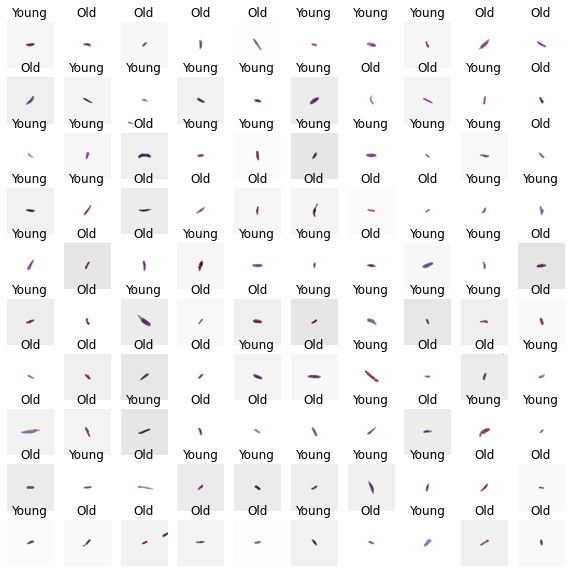

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(10,10))
for idx, elem in enumerate(train_labeled_ds.take(100)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(10,10,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')
plt.show()
target= 'sample_data'
if not os.path.exists(target): os.mkdir(target)
plt.savefig(target + '/aug10_all_training data.png')